# Quora Duplicate Question Pair Detection

# 1. Business Problem

## 1.1 Description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


### Problem Statement

Identify which questions asked on Quora are duplicates of questions that have already been asked.
This could be useful to instantly provide answers to questions that have already been answered.
We are tasked with predicting whether a pair of questions are duplicates or not.

### Huge Shout Out For

* Nitish Singh (CampusX)
* Udi Bhaskar (Git Hub)
* Kaggle

## 1.2 Sources/Useful Links

#### Source : https://www.kaggle.com/c/quora-question-pairs


#### Useful Links

* Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
* Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
* Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
* Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30


## 1.3 Real world/Business Objectives and Constraints

* The cost of a mis-classification can be very high.
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns.
* Interpretability is partially important.


# 2. Machine Learning Probelm

## 2.1 Data

### 2.1.1 Data Overview

- Data will be in a new_qoura_datset.csv
- new_quora_dataset.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate
- Size of new_quora_dataset.csv - 24 MB
- Number of rows in new_quora_dataset.csv = 4,04,290

### 2.1.2 Example Data point

* "id","qid1","qid2","question1","question2","is_duplicate"
* "0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"

* "1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
* "7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
* "11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

## 2.2 Mapping the real world problem to an ML problem

### 2.2.1 Type of Machine Leaning Problem

* It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.


### 2.2.2 Performance Metric

#### Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s):

* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

### 2.3 Train and Test Construction
* We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with.

## Basic Data Exploration

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re

In [4]:
data = pd.read_csv('new_quora_dataset.csv')
data.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

* There are very few outliers that, we should go ahead except of them

In [6]:
data.duplicated().sum()

0

* No duplicated values found.

## Distribution of duplicate and non-duplicate questions

0    255027
1    149263
Name: is_duplicate, dtype: int64
0    63.080215
1    36.919785
Name: is_duplicate, dtype: float64


<AxesSubplot:>

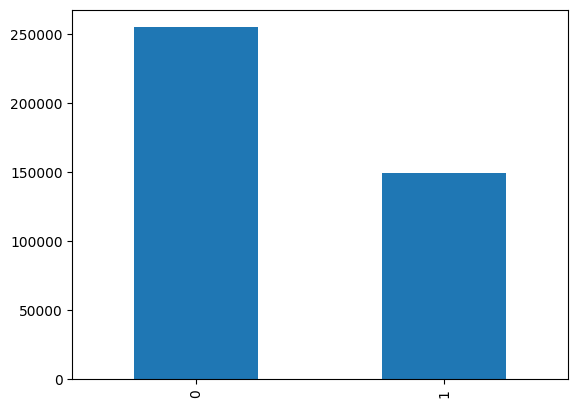

In [7]:
print(data['is_duplicate'].value_counts())
print((data['is_duplicate'].value_counts()/data['is_duplicate'].count())*100)
data['is_duplicate'].value_counts().plot(kind='bar')

## Repeated Questions

In [5]:
ques_id = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
print('Number of unique questions',np.unique(ques_id).shape[0])
x = ques_id.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 537933
Number of questions getting repeated 111780


## Repeated questions histogram

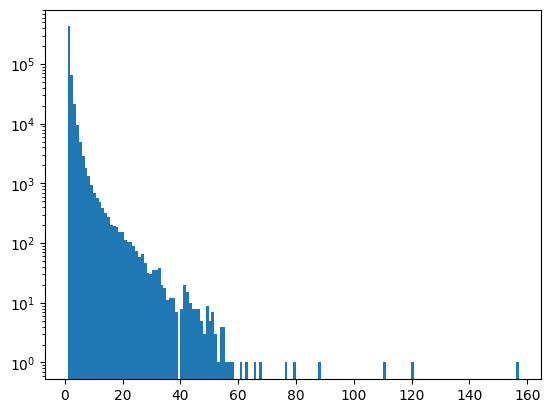

In [6]:
plt.hist(ques_id.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

* By this histogram we can interpret that, the question 1 to question 39 has majority number of frequency in the dataset.

### Here, we wll only use limited samples to work with however, if you have higher computation power than, make most of it.

In [9]:
new_data = data.sample(30000)
print(new_data.isnull().sum())
print(new_data.duplicated().sum())

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64
0


## Approach for Bag of Words

* Since we are only focusing on questions than, for bag of words model we will choose these features

In [10]:
ques_data = new_data[['question1','question2']]
ques_data.head()

question1  \
219048  Why is this girl ignoring my messages when I h...   
309489        How do I immigrate to Australia as a nurse?   
120159  What are some tips on making it through the jo...   
5882              What is the best niche to start a blog?   
34658   How much will it cost to put up a radio statio...   

                                                question2  
219048  When I send texts to my girlfriend through Fac...  
309489                How can you immigrate to Australia?  
120159  What are some tips on making it through the jo...  
5882           What is the perfect niche to start a blog?  
34658   How much will it cost to put up a radio station.?

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_data['question1']) + list(ques_data['question2'])

cou_vec = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cou_vec.fit_transform(questions).toarray(),2)

In [12]:
temp_data_1 = pd.DataFrame(q1_arr, index= ques_data.index)
temp_data_2 = pd.DataFrame(q2_arr, index= ques_data.index)
temp_data = pd.concat([temp_data_1, temp_data_2], axis=1)
temp_data.shape

(30000, 6000)

In [13]:
temp_data['is_duplicate'] = new_data['is_duplicate']
temp_data.head()

0  1  2  3  4  5  6  7  8  9  ...  2991  2992  2993  2994  2995  2996  \
219048  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
309489  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
120159  0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
5882    0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   
34658   0  0  0  0  0  0  0  0  0  0  ...     0     0     0     0     0     0   

        2997  2998  2999  is_duplicate  
219048     0     0     0             0  
309489     0     0     0             0  
120159     0     0     0             0  
5882       0     0     0             1  
34658      0     0     0             0  

[5 rows x 6001 columns]

## Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(temp_data.iloc[:, 0:-1].values,
                                                    temp_data.iloc[:, -1].values,
                                                    test_size=0.3,
                                                    random_state=1)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ran_f = RandomForestClassifier()
ran_f.fit(X_train,y_train)
y_pred = ran_f.predict(X_test)
accuracy_score(y_test, y_pred)

0.736

In [21]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test,y_pred)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\pkg_resources\__init__.py:126: PkgResourcesDeprecationWarning: e2510e7de8354ea89c54ab376ce52371efb39eff- is an invalid version and will not be supported in a future release
  PkgResourcesDeprecationWarning,


0.7227777777777777

* The accuracy which we recieved by both model is around 73, which needs further imporvement for better predictions. That is why, we will move on for feature engineering for more precise on every question.

## Feature Engineering 

In [14]:
# Length of questions

new_data['q1_len'] = new_data['question1'].str.len() 
new_data['q2_len'] = new_data['question2'].str.len()

In [15]:
# Number of words

new_data['q1_num_words'] = new_data['question1'].apply(lambda row: len(row.split(" ")))
new_data['q2_num_words'] = new_data['question2'].apply(lambda row: len(row.split(" ")))
new_data.head()

id    qid1    qid2  \
219048  219048   54305  325801   
309489  309489  433483  433484   
120159  120159  194938   59998   
5882      5882   11550   11551   
34658    34658   63468   63469   

                                                question1  \
219048  Why is this girl ignoring my messages when I h...   
309489        How do I immigrate to Australia as a nurse?   
120159  What are some tips on making it through the jo...   
5882              What is the best niche to start a blog?   
34658   How much will it cost to put up a radio statio...   

                                                question2  is_duplicate  \
219048  When I send texts to my girlfriend through Fac...             0   
309489                How can you immigrate to Australia?             0   
120159  What are some tips on making it through the jo...             0   
5882           What is the perfect niche to start a blog?             1   
34658   How much will it cost to put up a radio station.?             0   

        q1_len  q2_len  q1_num_words  q2_num_words  
219048      85     195            16            35  
309489      43      35             9             6  
120159      90      83            15            15  
5882        39      42             9             9  
34658       62      49            13            11

In [16]:
# Count of common words

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

new_data['common_words'] = new_data.apply(common_words, axis=1)
new_data.head()

id    qid1    qid2  \
219048  219048   54305  325801   
309489  309489  433483  433484   
120159  120159  194938   59998   
5882      5882   11550   11551   
34658    34658   63468   63469   

                                                question1  \
219048  Why is this girl ignoring my messages when I h...   
309489        How do I immigrate to Australia as a nurse?   
120159  What are some tips on making it through the jo...   
5882              What is the best niche to start a blog?   
34658   How much will it cost to put up a radio statio...   

                                                question2  is_duplicate  \
219048  When I send texts to my girlfriend through Fac...             0   
309489                How can you immigrate to Australia?             0   
120159  What are some tips on making it through the jo...             0   
5882           What is the perfect niche to start a blog?             1   
34658   How much will it cost to put up a radio station.?             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  
219048      85     195            16            35             7  
309489      43      35             9             6             3  
120159      90      83            15            15            14  
5882        39      42             9             9             8  
34658       62      49            13            11            10

In [17]:
# Count of total words

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

new_data['total_words'] = new_data.apply(total_words, axis=1)
new_data.head()

id    qid1    qid2  \
219048  219048   54305  325801   
309489  309489  433483  433484   
120159  120159  194938   59998   
5882      5882   11550   11551   
34658    34658   63468   63469   

                                                question1  \
219048  Why is this girl ignoring my messages when I h...   
309489        How do I immigrate to Australia as a nurse?   
120159  What are some tips on making it through the jo...   
5882              What is the best niche to start a blog?   
34658   How much will it cost to put up a radio statio...   

                                                question2  is_duplicate  \
219048  When I send texts to my girlfriend through Fac...             0   
309489                How can you immigrate to Australia?             0   
120159  What are some tips on making it through the jo...             0   
5882           What is the perfect niche to start a blog?             1   
34658   How much will it cost to put up a radio station.?             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  
219048      85     195            16            35             7           47  
309489      43      35             9             6             3           15  
120159      90      83            15            15            14           30  
5882        39      42             9             9             8           18  
34658       62      49            13            11            10           24

In [18]:
# Word shared between each question

new_data['word_share'] = round(new_data['common_words']/new_data['total_words'], 2)
new_data.head()

id    qid1    qid2  \
219048  219048   54305  325801   
309489  309489  433483  433484   
120159  120159  194938   59998   
5882      5882   11550   11551   
34658    34658   63468   63469   

                                                question1  \
219048  Why is this girl ignoring my messages when I h...   
309489        How do I immigrate to Australia as a nurse?   
120159  What are some tips on making it through the jo...   
5882              What is the best niche to start a blog?   
34658   How much will it cost to put up a radio statio...   

                                                question2  is_duplicate  \
219048  When I send texts to my girlfriend through Fac...             0   
309489                How can you immigrate to Australia?             0   
120159  What are some tips on making it through the jo...             0   
5882           What is the perfect niche to start a blog?             1   
34658   How much will it cost to put up a radio station.?             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  \
219048      85     195            16            35             7           47   
309489      43      35             9             6             3           15   
120159      90      83            15            15            14           30   
5882        39      42             9             9             8           18   
34658       62      49            13            11            10           24   

        word_share  
219048        0.15  
309489        0.20  
120159        0.47  
5882          0.44  
34658         0.42

## Analysis on features

* We will see the distrbution of each feature by analysing through their counts.

Minimum characters 1
Maximum characters 370
Average num of characters 59


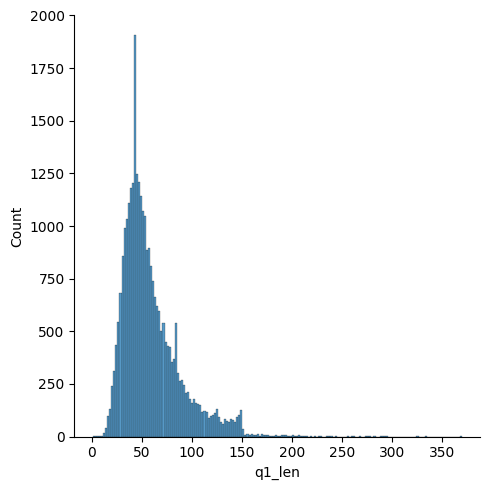

In [19]:
# Analysis of features

sns.displot(new_data['q1_len'])
print('Minimum characters',new_data['q1_len'].min())
print('Maximum characters',new_data['q1_len'].max())
print('Average num of characters',int(new_data['q1_len'].mean()))

Minimum characters 5
Maximum characters 1151
Average num of characters 59


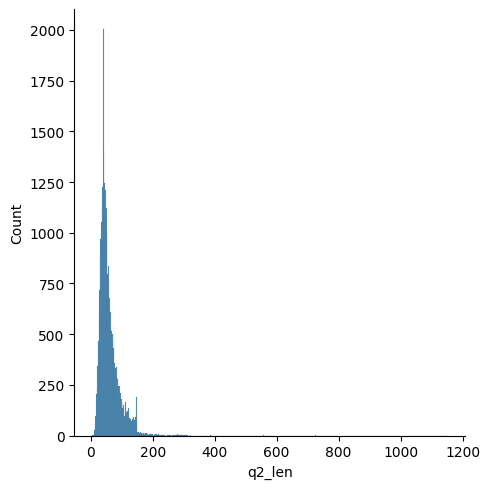

In [20]:
sns.displot(new_data['q2_len'])
print('Minimum characters',new_data['q2_len'].min())
print('Maximum characters',new_data['q2_len'].max())
print('Average num of characters',int(new_data['q2_len'].mean()))

Minimum words 1
Maximum words 73
Average num of words 10


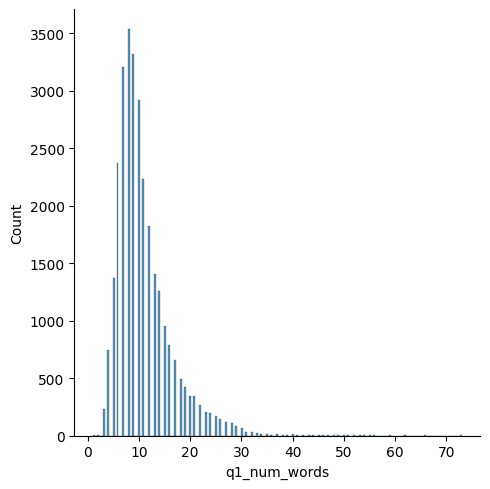

In [21]:
sns.displot(new_data['q1_num_words'])
print('Minimum words',new_data['q1_num_words'].min())
print('Maximum words',new_data['q1_num_words'].max())
print('Average num of words',int(new_data['q1_num_words'].mean()))

Minimum words 1
Maximum words 237
Average num of words 11


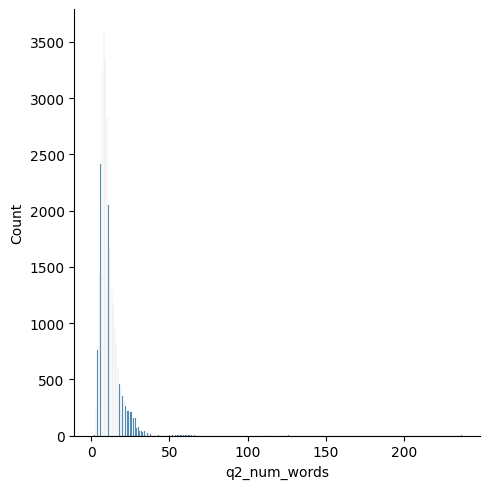

In [22]:
sns.displot(new_data['q2_num_words'])
print('Minimum words',new_data['q2_num_words'].min())
print('Maximum words',new_data['q2_num_words'].max())
print('Average num of words',int(new_data['q2_num_words'].mean()))

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


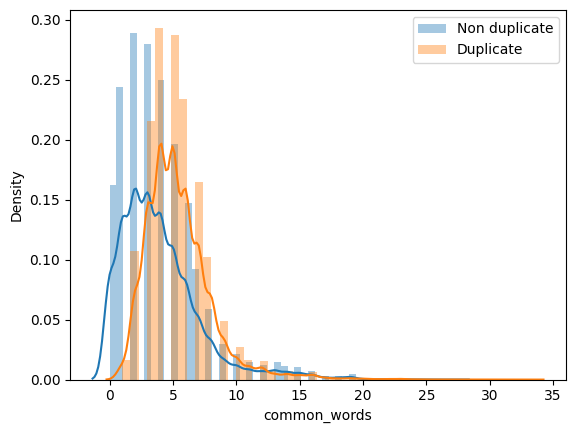

In [23]:
# Common words

sns.distplot(new_data[new_data['is_duplicate'] == 0]['common_words'],label='Non duplicate')
sns.distplot(new_data[new_data['is_duplicate'] == 1]['common_words'],label='Duplicate')
plt.legend()
plt.show()

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


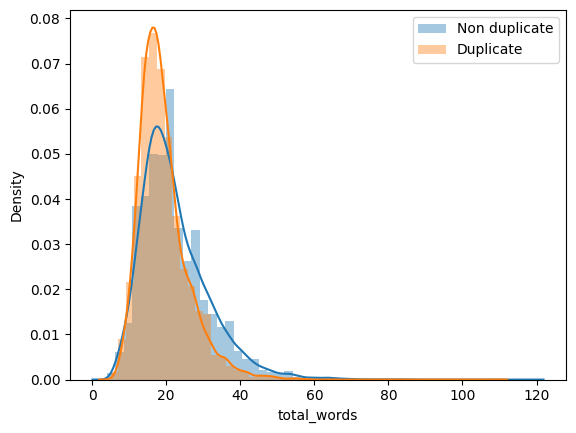

In [35]:
# Total words

sns.distplot(new_data[new_data['is_duplicate'] == 0]['total_words'],label='Non duplicate')
sns.distplot(new_data[new_data['is_duplicate'] == 1]['total_words'],label='Duplicate')
plt.legend()
plt.show()

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


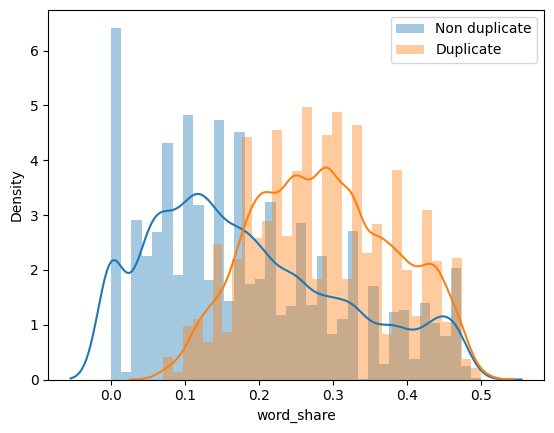

In [36]:
# Words share

sns.distplot(new_data[new_data['is_duplicate'] == 0]['word_share'],label='Non duplicate')
sns.distplot(new_data[new_data['is_duplicate'] == 1]['word_share'],label='Duplicate')
plt.legend()
plt.show()

* By this distribution, we can assume that the simliratiy of both question has majority of overalapping probability.

In [13]:
ques_data = new_data[['question1','question2']]
ques_data.head()

question1  \
244593           What all can I talk about with my crush?   
344805  Where can I get a Baby Marginated Tortoise in ...   
326753  Where in Southeast Asia can I live comfortably...   
52585                        How do I run Python on WAMP?   
396624  Why are the former French colonies comparative...   

                                                question2  
244593            What should I talk about with my crush?  
344805  Is there any way to make my room (in new delhi...  
326753  Where can I find a US intern willing to do a 6...  
52585   When is iron maiden playing in my area I live ...  
396624  Why are former British colonies doing so well ...

In [14]:
# Removing unnecessary features

final_data = new_data.drop(['id','qid1','qid2','question1','question2'], axis=1)
print(final_data.shape)
final_data.head()

(30000, 8)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  \
244593             1      40      39             9             8   
344805             0      56      65            10            15   
326753             0      66      75            12            16   
52585              0      28      68             7            13   
396624             0      90     150            14            21   

        common_words  total_words  word_share  
244593             7           17        0.41  
344805             0           25        0.00  
326753             5           27        0.19  
52585              1           19        0.05  
396624             6           32        0.19

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_data['question1']) + list(ques_data['question2'])

cou_vec = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cou_vec.fit_transform(questions).toarray(),2)

In [16]:
temp_data_1 = pd.DataFrame(q1_arr, index= ques_data.index)
temp_data_2 = pd.DataFrame(q2_arr, index= ques_data.index)
temp_data = pd.concat([temp_data_1, temp_data_2], axis=1)
temp_data.shape

(30000, 6000)

In [17]:
# Concatinating the encoded end feature engineered data

final_data = pd.concat([final_data, temp_data], axis=1)
print(final_data.shape)
final_data.head()

(30000, 6008)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  \
244593             1      40      39             9             8   
344805             0      56      65            10            15   
326753             0      66      75            12            16   
52585              0      28      68             7            13   
396624             0      90     150            14            21   

        common_words  total_words  word_share  0  1  ...  2990  2991  2992  \
244593             7           17        0.41  0  0  ...     0     0     0   
344805             0           25        0.00  0  0  ...     0     0     0   
326753             5           27        0.19  0  0  ...     0     0     0   
52585              1           19        0.05  0  0  ...     0     0     0   
396624             6           32        0.19  0  0  ...     0     0     0   

        2993  2994  2995  2996  2997  2998  2999  
244593     0     0     0     0     0     0     0  
344805     0     0     0     0     0     0     0  
326753     0     0     0     0     0     0     0  
52585      0     0     0     0     0     0     0  
396624     0     0     0     0     0     0     0  

[5 rows x 6008 columns]

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_data.iloc[:,1:].values,
                                                    final_data.iloc[:,0].values,
                                                    test_size=0.3,
                                                    random_state=1)

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ran_f = RandomForestClassifier()
ran_f.fit(X_train, y_train)
y_pred = ran_f.predict(X_test)
accuracy_score(y_test, y_pred)

0.7606666666666667

In [44]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy_score(y_test,y_pred)

0.7615555555555555

* Accuracy is still needs to be improved, that is why the further feature engineering is necessary by removing some 
stop words or repeated words.

## Advanced Feature Engineering

In [18]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [19]:
preprocess("Everyone is going to home, now.")

'everyone is going to home  now'

In [20]:
new_data['question1'] = new_data['question1'].apply(preprocess)
new_data['question2'] = new_data['question2'].apply(preprocess)

C:\Users\hp\Anaconda3\lib\site-packages\bs4\__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [21]:
new_data['q1_len'] = new_data['question1'].str.len() 
new_data['q2_len'] = new_data['question2'].str.len()

In [22]:
new_data['q1_num_words'] = new_data['question1'].apply(lambda row: len(row.split(" ")))
new_data['q2_num_words'] = new_data['question2'].apply(lambda row: len(row.split(" ")))
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  \
244593      39      38             9             8             7           17   
344805      55      64            10            17             0           25   
326753      70      74            14            16             5           27   
52585       27      67             7            13             1           19   
396624      89     148            14            25             6           32   

        word_share  
244593        0.41  
344805        0.00  
326753        0.19  
52585         0.05  
396624        0.19

In [23]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [24]:
new_data['common_words'] = new_data.apply(common_words, axis=1)
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  \
244593      39      38             9             8             7           17   
344805      55      64            10            17             1           25   
326753      70      74            14            16             6           27   
52585       27      67             7            13             1           19   
396624      89     148            14            25             7           32   

        word_share  
244593        0.41  
344805        0.00  
326753        0.19  
52585         0.05  
396624        0.19

In [25]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [26]:
new_data['total_words'] = new_data.apply(total_words, axis=1)
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  \
244593      39      38             9             8             7           17   
344805      55      64            10            17             1           26   
326753      70      74            14            16             6           29   
52585       27      67             7            13             1           19   
396624      89     148            14            25             7           35   

        word_share  
244593        0.41  
344805        0.00  
326753        0.19  
52585         0.05  
396624        0.19

In [27]:
new_data['word_share'] = round(new_data['common_words']/new_data['total_words'], 2)
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  common_words  total_words  \
244593      39      38             9             8             7           17   
344805      55      64            10            17             1           26   
326753      70      74            14            16             6           29   
52585       27      67             7            13             1           19   
396624      89     148            14            25             7           35   

        word_share  
244593        0.41  
344805        0.04  
326753        0.21  
52585         0.05  
396624        0.20

In [28]:
# Advanced Features

from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [29]:
token_features = new_data.apply(fetch_token_features, axis=1)

new_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_data["csc_min"]       = list(map(lambda x: x[2], token_features))
new_data["csc_max"]       = list(map(lambda x: x[3], token_features))
new_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_data["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [30]:
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...  total_words  \
244593      39      38             9             8  ...           17   
344805      55      64            10            17  ...           26   
326753      70      74            14            16  ...           29   
52585       27      67             7            13  ...           19   
396624      89     148            14            25  ...           35   

        word_share   cwc_min   cwc_max   csc_min   csc_max   ctc_min  \
244593        0.41  0.999950  0.999950  0.833319  0.714276  0.874989   
344805        0.04  0.000000  0.000000  0.199996  0.142855  0.099999   
326753        0.21  0.124998  0.124998  0.833319  0.714276  0.428568   
52585         0.05  0.000000  0.000000  0.249994  0.199996  0.142855   
396624        0.20  0.499994  0.333331  0.599988  0.333330  0.499996   

         ctc_max  last_word_eq  first_word_eq  
244593  0.777769           1.0            1.0  
344805  0.066666           0.0            0.0  
326753  0.374998           0.0            1.0  
52585   0.076922           0.0            0.0  
396624  0.304347           0.0            1.0  

[5 rows x 21 columns]

In [31]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into tokens 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [32]:
length_features = new_data.apply(fetch_length_features, axis=1)

new_data['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_data['mean_len'] = list(map(lambda x: x[1], length_features))
new_data['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [34]:
new_data.head()

id    qid1    qid2  \
244593  244593  357257  357258   
344805  344805  473066  473067   
326753  326753  164842  453116   
52585    52585   93085   93086   
396624  396624  424145  111386   

                                                question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  is_duplicate  \
244593             what should i talk about with my crush             1   
344805  is there any way to make my room  in new delhi...             0   
326753  where can i find a us intern willing to do a 6...             0   
52585   when is iron maiden playing in my area i live ...             0   
396624  why are former british colonies doing so well ...             0   

        q1_len  q2_len  q1_num_words  q2_num_words  ...   cwc_max   csc_min  \
244593      39      38             9             8  ...  0.999950  0.833319   
344805      55      64            10            17  ...  0.000000  0.199996   
326753      70      74            14            16  ...  0.124998  0.833319   
52585       27      67             7            13  ...  0.000000  0.249994   
396624      89     148            14            25  ...  0.333331  0.599988   

         csc_max   ctc_min   ctc_max  last_word_eq  first_word_eq  \
244593  0.714276  0.874989  0.777769           1.0            1.0   
344805  0.142855  0.099999  0.066666           0.0            0.0   
326753  0.714276  0.428568  0.374998           0.0            1.0   
52585   0.199996  0.142855  0.076922           0.0            0.0   
396624  0.333330  0.499996  0.304347           0.0            1.0   

        abs_len_diff  mean_len  longest_substr_ratio  
244593           1.0       8.5              0.692308  
344805           5.0      12.5              0.089286  
326753           2.0      15.0              0.098592  
52585            6.0      10.0              0.107143  
396624           9.0      18.5              0.188889  

[5 rows x 24 columns]

#### Here we are using fuzzy features for better feature processsing.

### Why fuzzy feature is required?
* Fuzzy feature selection is based on a fuzzy entropy measure. Since the fuzzy entropy is able to discriminate pattern 
distribution better, it is employed to evaluate the separability of each feature. Intuitively, the lower the fuzzy entropy 
of a feature, the higher is the feature's discriminating ability.

In [35]:
# Fuzzy Features

from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # Fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # Fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # Token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # Token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

C:\Users\hp\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [36]:
fuzzy_features = new_data.apply(fetch_fuzzy_features, axis=1)


# Creating new feature columns for fuzzy features

new_data['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_data['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_data['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_data['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

## Analysis of Advanced Features

* By visualizing this, we can see the relationship between each advanced feature to target feature. 

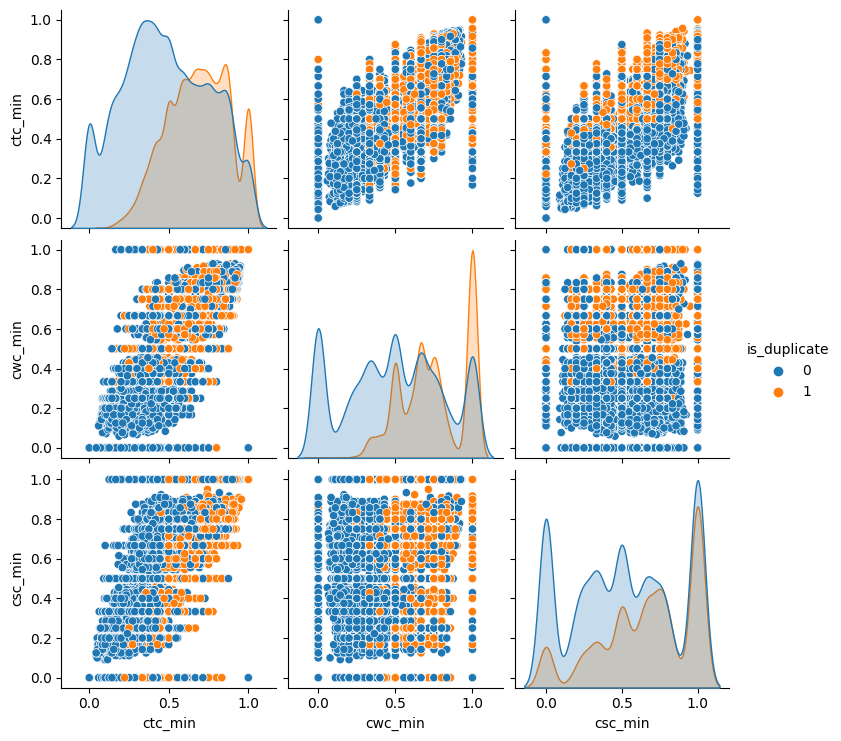

In [37]:
sns.pairplot(new_data[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

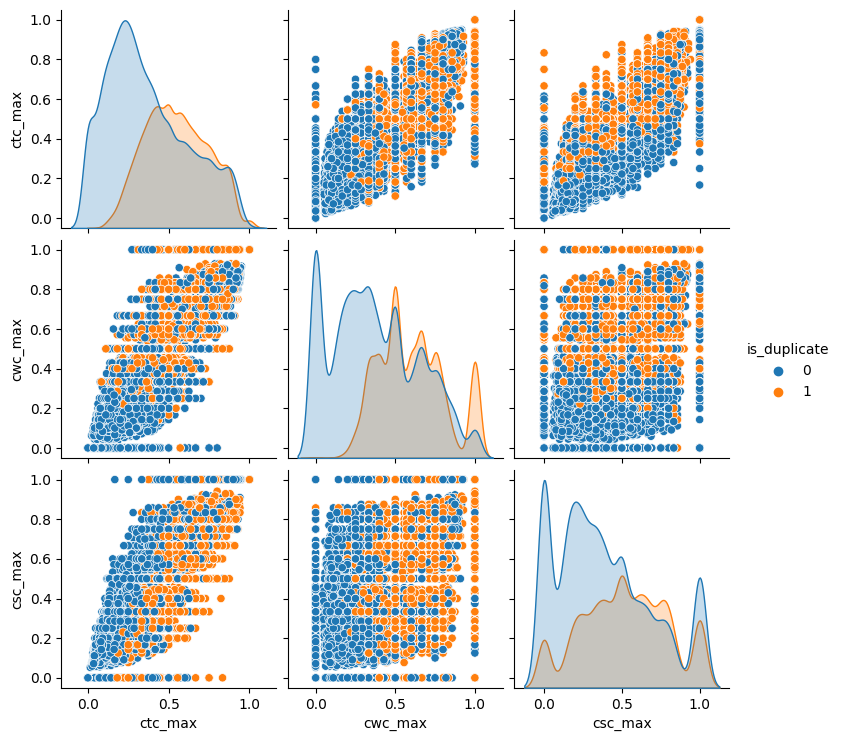

In [38]:
sns.pairplot(new_data[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

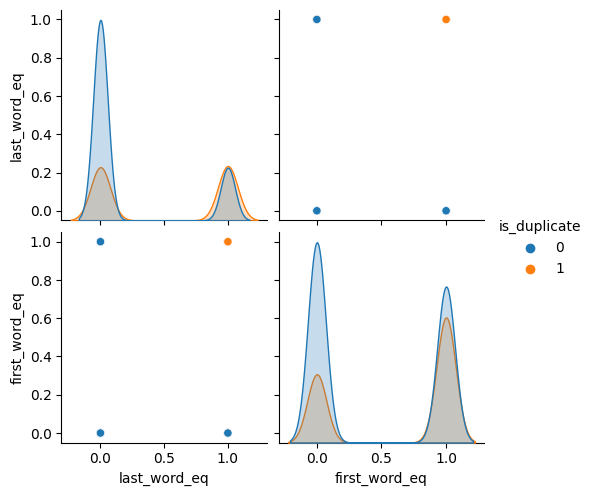

In [39]:
sns.pairplot(new_data[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

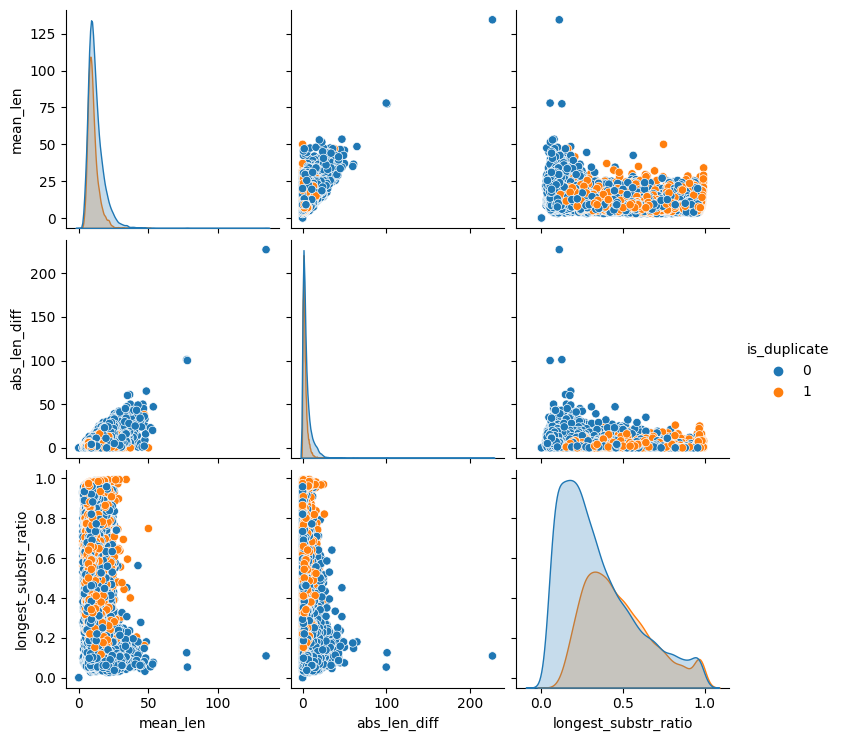

In [40]:
sns.pairplot(new_data[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

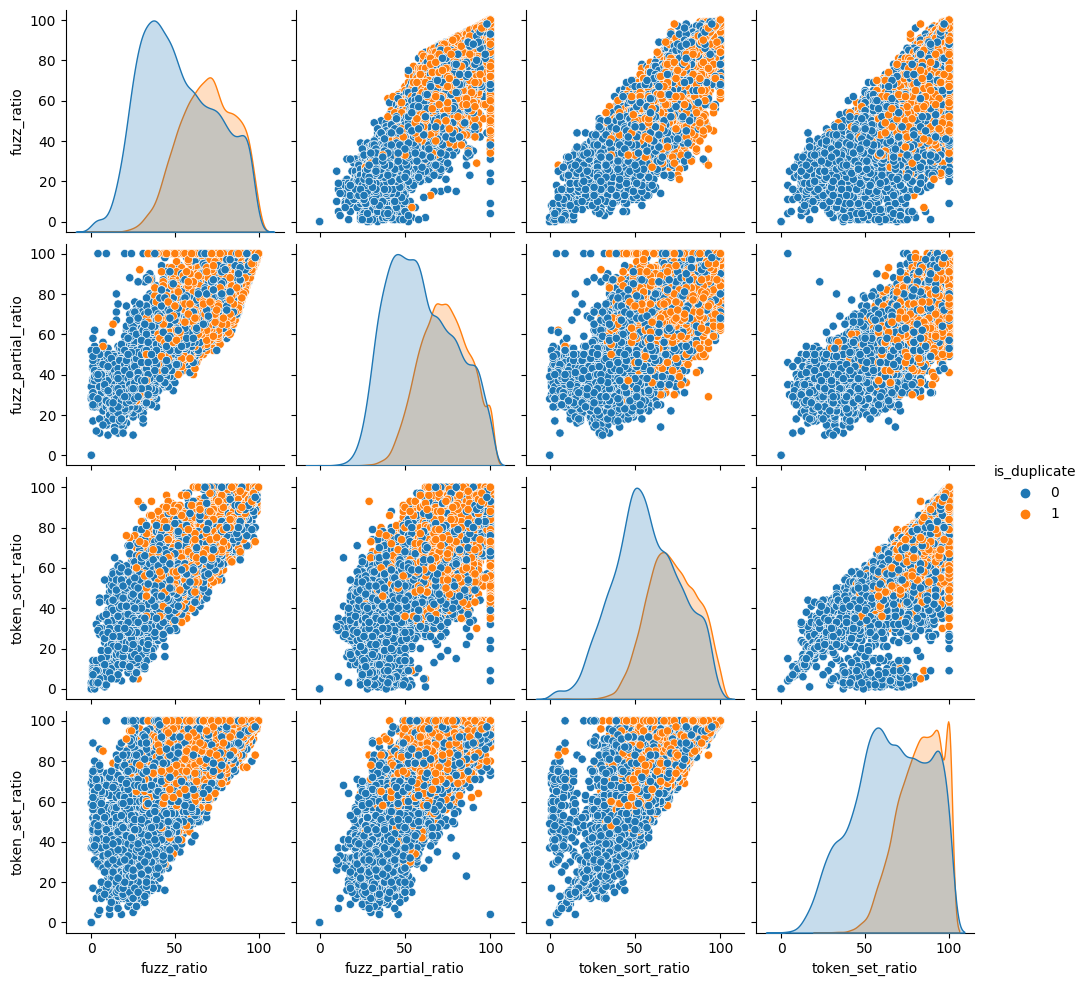

In [41]:
sns.pairplot(new_data[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

### Here, we will normalizing our features for TSNE Method for Dimensionality reduction.

In [42]:
from sklearn.preprocessing import MinMaxScaler

X = MinMaxScaler().fit_transform(new_data[['cwc_min', 'cwc_max', 'csc_min', 
                                           'csc_max' , 'ctc_min' , 'ctc_max' , 
                                           'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 
                                           'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  
                                           'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = new_data['is_duplicate'].values

In [43]:
from sklearn.manifold import TSNE

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.126s...
[t-SNE] Computed neighbors for 30000 samples in 4.392s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


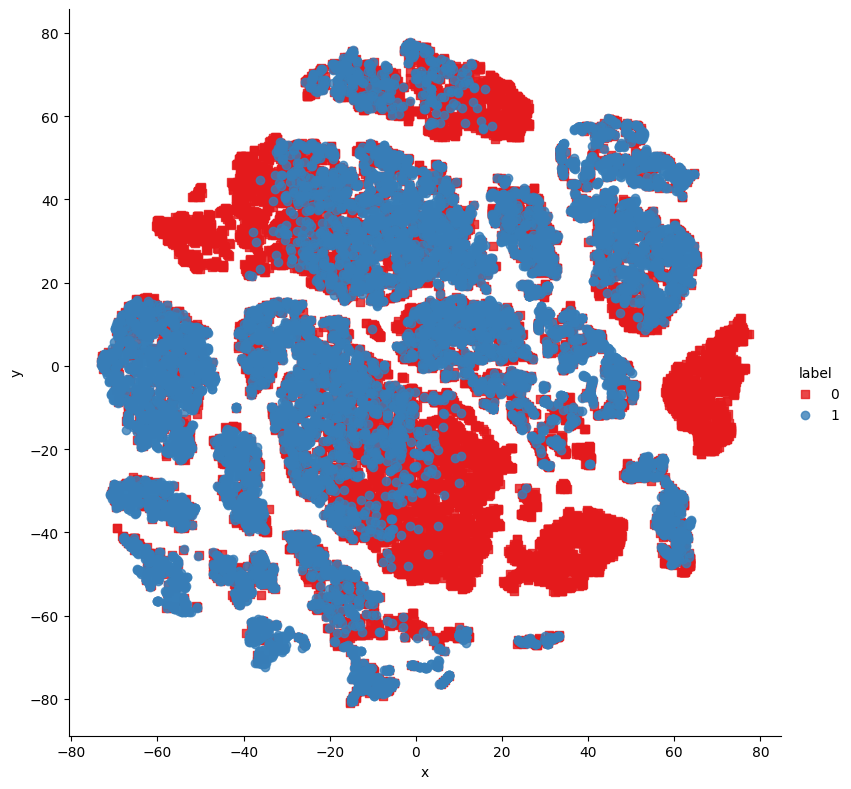

In [44]:
X_df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=X_df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])


In [45]:
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.123s...
[t-SNE] Computed neighbors for 30000 samples in 4.409s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sam

In [47]:
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.offline as py
py.init_notebook_mode(connected=True)

trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d Embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [48]:
ques_data = new_data[['question1','question2']]
ques_data.head()

question1  \
244593            what all can i talk about with my crush   
344805  where can i get a baby marginated tortoise in ...   
326753  where in southeast asia can i live comfortably...   
52585                         how do i run python on wamp   
396624  why are the former french colonies comparative...   

                                                question2  
244593             what should i talk about with my crush  
344805  is there any way to make my room  in new delhi...  
326753  where can i find a us intern willing to do a 6...  
52585   when is iron maiden playing in my area i live ...  
396624  why are former british colonies doing so well ...

In [49]:
final_data = new_data.drop(['id','qid1','qid2','question1','question2'], axis=1)
print(final_data.shape)
final_data.head()

(30000, 23)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  \
244593             1      39      38             9             8   
344805             0      55      64            10            17   
326753             0      70      74            14            16   
52585              0      27      67             7            13   
396624             0      89     148            14            25   

        common_words  total_words  word_share   cwc_min   cwc_max  ...  \
244593             7           17        0.41  0.999950  0.999950  ...   
344805             1           26        0.04  0.000000  0.000000  ...   
326753             6           29        0.21  0.124998  0.124998  ...   
52585              1           19        0.05  0.000000  0.000000  ...   
396624             7           35        0.20  0.499994  0.333331  ...   

         ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
244593  0.777769           1.0            1.0           1.0       8.5   
344805  0.066666           0.0            0.0           5.0      12.5   
326753  0.374998           0.0            1.0           2.0      15.0   
52585   0.076922           0.0            0.0           6.0      10.0   
396624  0.304347           0.0            1.0           9.0      18.5   

        longest_substr_ratio  fuzz_ratio  fuzz_partial_ratio  \
244593              0.692308          86                  84   
344805              0.089286          37                  38   
326753              0.098592          42                  43   
52585               0.107143          21                  41   
396624              0.188889          43                  49   

        token_sort_ratio  token_set_ratio  
244593                81               90  
344805                36               39  
326753                53               54  
52585                 23               26  
396624                57               66  

[5 rows x 23 columns]

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

questions = list(ques_data['question1']) + list(ques_data['question2'])

cou_vec = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cou_vec.fit_transform(questions).toarray(),2)

In [51]:
temp_data_1 = pd.DataFrame(q1_arr, index= ques_data.index)
temp_data_2 = pd.DataFrame(q2_arr, index= ques_data.index)
temp_data = pd.concat([temp_data_1, temp_data_2], axis=1)
temp_data.shape

(30000, 6000)

In [52]:
final_data = pd.concat([final_data, temp_data], axis=1)
print(final_data.shape)
final_data.head()

(30000, 6023)


is_duplicate  q1_len  q2_len  q1_num_words  q2_num_words  \
244593             1      39      38             9             8   
344805             0      55      64            10            17   
326753             0      70      74            14            16   
52585              0      27      67             7            13   
396624             0      89     148            14            25   

        common_words  total_words  word_share   cwc_min   cwc_max  ...  2990  \
244593             7           17        0.41  0.999950  0.999950  ...     0   
344805             1           26        0.04  0.000000  0.000000  ...     0   
326753             6           29        0.21  0.124998  0.124998  ...     0   
52585              1           19        0.05  0.000000  0.000000  ...     0   
396624             7           35        0.20  0.499994  0.333331  ...     0   

        2991  2992  2993  2994  2995  2996  2997  2998  2999  
244593     0     0     0     0     0     0     0     0     0  
344805     0     0     0     0     0     0     0     0     0  
326753     0     0     0     0     0     0     0     0     0  
52585      0     0     0     0     0     0     0     0     0  
396624     0     0     0     0     0     0     0     0     0  

[5 rows x 6023 columns]

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_data.iloc[:, 1:].values,
                                                    final_data.iloc[:, 0].values,
                                                    test_size=0.3,
                                                    random_state=1)

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ran_f = RandomForestClassifier()
ran_f.fit(X_train, y_train)
y_pred = ran_f.predict(X_test)
accuracy_score(y_test, y_pred)

0.7837777777777778

In [56]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
y_pred_ano = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred_ano)

0.7874444444444444

<AxesSubplot:>

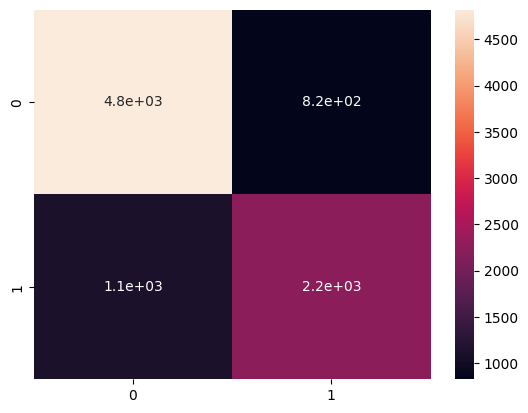

In [57]:
from sklearn.metrics import confusion_matrix as cm

sns.heatmap(cm(y_test,y_pred), annot=True)

<AxesSubplot:>

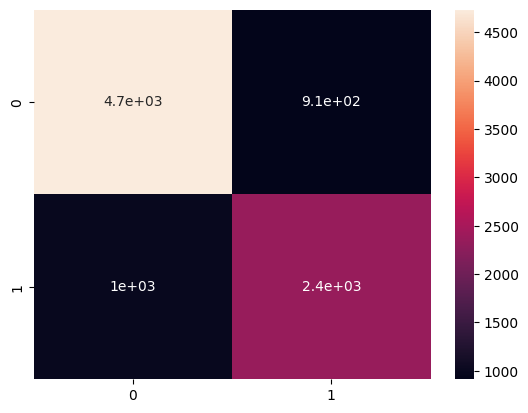

In [58]:
sns.heatmap(cm(y_test,y_pred_ano), annot=True)

#### Accuracy is good till now, however this can be further improved by in the future work but, till than testing the random forest model for our web application.

In [59]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [60]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [61]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features

In [62]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

In [63]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # Fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # Fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # Token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # Token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [67]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cou_vec.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cou_vec.transform([q2]).toarray()
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

## Final Query Testing

In [65]:
q1 = 'Who is the spider-man?'
q2 = 'Who is the new spider-man'
q3 = 'How to go home?'
q4 = 'How to go home by this way?'

In [70]:
ran_f.predict(query_point_creator(q3,q4))

array([1], dtype=int64)

## Serializing the Model and Count Vecorizer

In [72]:
import pickle

pickle.dump(ran_f,open('ran_for_model.pkl','wb'))
pickle.dump(cou_vec,open('cou_vec.pkl','wb'))